# Анализ на [Adult Census Income Data Set](https://archive.ics.uci.edu/ml/datasets/census+income)

Даденият dataset съдържа информация за различни хора, набавена при преброяването на неселението през 1994 г. 
Основната задача е да се предскаже дали даден човек изкарва повече от 50 000 на година.

[Kaggle](https://www.kaggle.com/uciml/adult-census-income)


In [4]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


Да заредим данните:


In [5]:
data = pd.read_csv('data/adult-census-income/adult.csv')

In [6]:
print("Rows: {}".format(data.shape[0]))
print("Columns: {}".format(data.shape[1]))

Rows: 32561
Columns: 15


In [7]:
data.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K


Колоната, която ще предсказваме, се казва "**income**" и съдържа една от две стойности:
* <=50K - хората, изкарващи 50к или по-малко
* \>50K - хората, изкарващи повече от 50к


In [8]:
data.income.value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

Ще е по-лесно, ако представим стойностите на тази колона като 0 и 1. 

0 за 50к или по-малко; 1 за повече от 50к.


In [9]:
data['income'] = (data['income'] == '>50K').astype(int)

In [10]:
data.income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

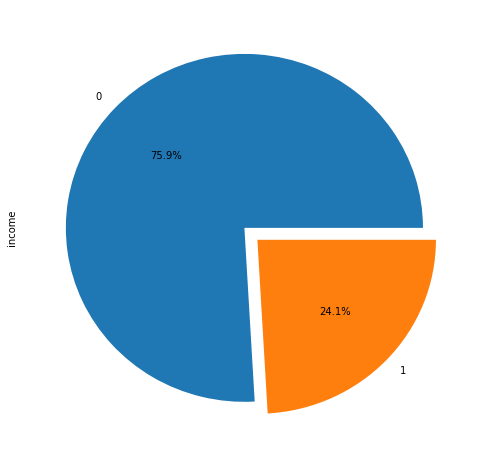

In [11]:
data.income.value_counts().plot.pie(
    explode=[0, 0.1], 
    figsize=(8, 8), 
    autopct='%1.1f%%');

Виждаме също така, че данните са небалансирани. Имаме доста по-малко записи за хора, които изкарват над 50к.

Следователно ако направим "тъп" модел, който предсказва винаги 0, ще имаме близo 76% успеваемост. Гоним повече от това.

# Data Exploration

Нека разгледаме данните

In [12]:
continuos_cols = data.describe().columns
categorical_cols = data.select_dtypes(include=['object']).columns

print("Continuous columns(len : {}): {}".format(
    len(continuos_cols), 
    continuos_cols.values))

print()

print("Categorical columns(len: {}): {}".format(
    len(categorical_cols),
    categorical_cols.values))

Continuous columns(len : 7): ['age' 'fnlwgt' 'education.num' 'capital.gain' 'capital.loss'
 'hours.per.week' 'income']

Categorical columns(len: 8): ['workclass' 'education' 'marital.status' 'occupation' 'relationship'
 'race' 'sex' 'native.country']


Виждаме, че имаме 6 колони с непрекъснати данни (като изключим income) и 8 колони с категорни данни.

Ще разгледаме първо непрекъснатите данни.

### Age

In [13]:
data.age.describe()

count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [14]:
print("Null age values count: {}".format(data.age.isnull().sum()))

Null age values count: 0


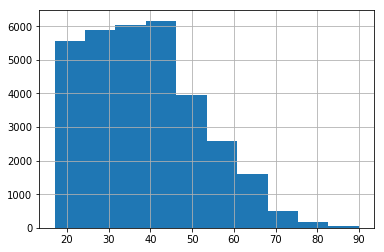

In [15]:
data.age.hist();

Виждаме, че годините са в доста голям range - от 17 до 90 годишни. Най много представители имаме в диапазона 25-45 години.

Нека да видим как се вписва дохода при годините:

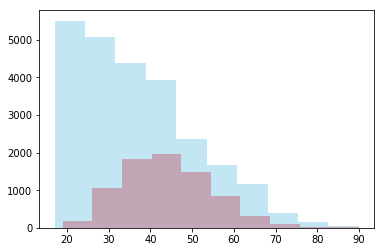

In [16]:
plt.hist(list(data[data.income == 1]['age']), alpha=0.5, color="red");
plt.hist(list(data[data.income == 0]['age']), alpha=0.5, color="skyblue");

In [17]:
print("Mean of age for '>50k': {}".format(data[data.income == 1]['age'].mean()))
print("Mean of age for '<=50k': {}".format(data[data.income == 0]['age'].mean()))

Mean of age for '>50k': 44.24984058155847
Mean of age for '<=50k': 36.78373786407767


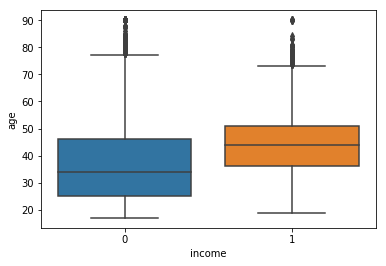

In [18]:
sns.boxplot(x='income', y='age', data=data);

От графиката и от средните стойности горе виждаме, че възрастта играе роля в това дали изкарваш над или под 50к. Средно, изкарващите над 50к, са по-възрастни.

### Hours Per Week

In [19]:
data['hours.per.week'].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours.per.week, dtype: float64

In [20]:
print("Null hours.per.week values count: {}".format(data['hours.per.week'].isnull().sum()))

Null hours.per.week values count: 0


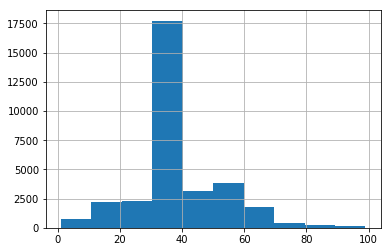

In [21]:
data['hours.per.week'].hist();

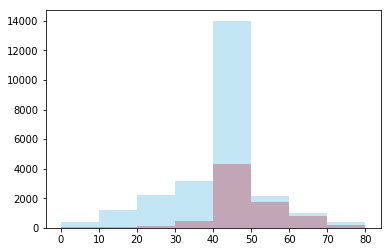

In [22]:
bins=[0, 10, 20, 30, 40, 50, 60, 70, 80]

plt.hist(list(data[data.income == 1]['hours.per.week']), alpha=0.5, color="red", bins=bins);
plt.hist(list(data[data.income == 0]['hours.per.week']), alpha=0.5, color="skyblue", bins=bins);

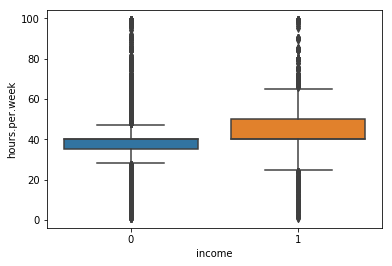

In [23]:
sns.boxplot(x='income', y='hours.per.week', data=data);

Повечето хора работят към 40 часа на седмица, което е напълно в реда на нещата. Интересно е, че рязко се увеличава процентът от хора, изкарващи над 50к, които работят над 40-45 часа седмично. 

Определно тук виждаме зависимост между часовете и дохода.

### Education Num

In [24]:
data['education.num'].describe()

count    32561.000000
mean        10.080679
std          2.572720
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         16.000000
Name: education.num, dtype: float64

In [25]:
print("Null education.num values count: {}".format(data['education.num'].isnull().sum()))

Null education.num values count: 0


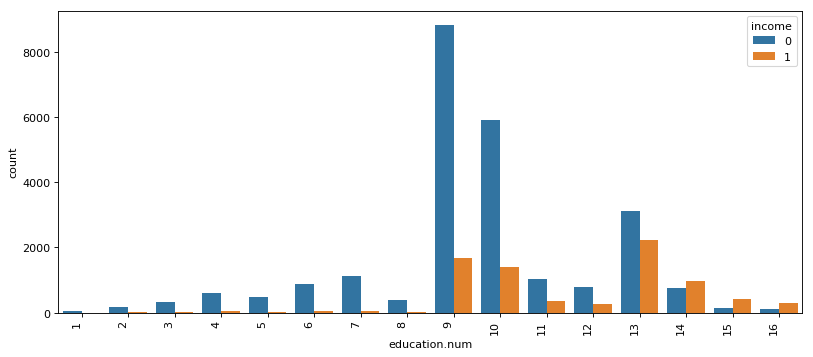

In [26]:
plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot('education.num', hue='income', data=data)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

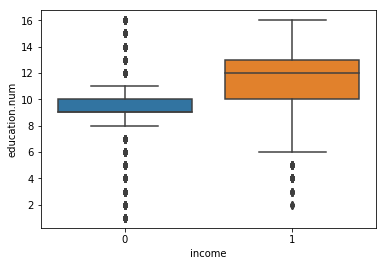

In [27]:
sns.boxplot(x='income', y='education.num', data=data);

Логично, колкото повече години учиш, толкова по-голям шанс има да изкарваш над 50к.

Горе видяхме, че има един друг, категориен атрибут, който се казва "education". По пътя на логиката, education и education.num трябва да са зависими. Ще проверим после, когато разглеждаме категорийните feature-и.

### Capital Gain & Capital Loss

In [28]:
data['capital.gain'].describe()

count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital.gain, dtype: float64

In [29]:
data['capital.loss'].describe()

count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital.loss, dtype: float64

In [30]:
print("Null capital.gain values count: {}".format(data['capital.gain'].isnull().sum()))
print("Null capital.loss values count: {}".format(data['capital.loss'].isnull().sum()))

Null capital.gain values count: 0
Null capital.loss values count: 0


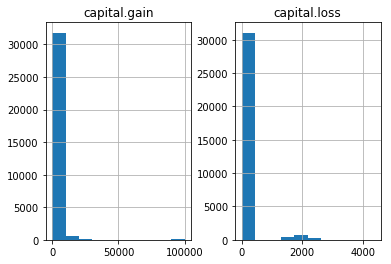

In [31]:
data[['capital.gain', 'capital.loss']].hist();

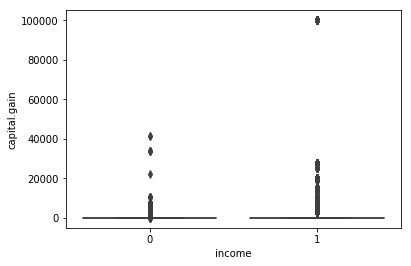

In [32]:
sns.boxplot(x='income', y='capital.gain', data=data);

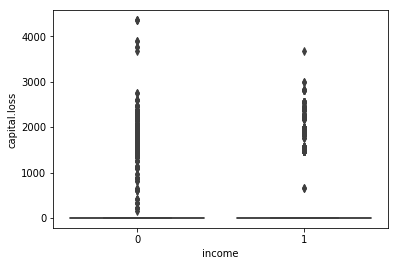

In [33]:
sns.boxplot(x='income', y='capital.loss', data=data);

In [34]:
def percentage(part, whole):
    return 100 * float(part)/float(whole)

def zeroes_percentage(col_name):
    total_rows = data.shape[0]
    zeros_rows = data[data[col_name] == 0].shape[0]
    
    return percentage(zeros_rows, total_rows)

In [35]:
print("{0:.2f} % of rows have value 0 for capital.gain.".format(zeroes_percentage('capital.gain')))
print("{0:.2f} % of rows have value 0 for capital.loss.".format(zeroes_percentage('capital.loss')))

91.67 % of rows have value 0 for capital.gain.
95.33 % of rows have value 0 for capital.loss.


Капиталовата печалба и загуба се състоят почти само от нули. Не ми прилича на особено полезен фийчър при класификацията.

### Final weight (fnlwgt)

In [36]:
data.fnlwgt.describe()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64

In [37]:
print("Null fnlwgt values count: {}".format(data['fnlwgt'].isnull().sum()))

Null fnlwgt values count: 0


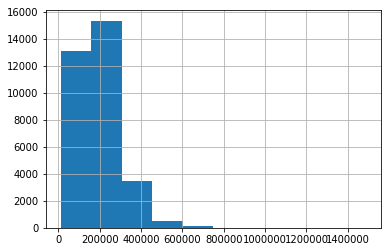

In [38]:
data.fnlwgt.hist();

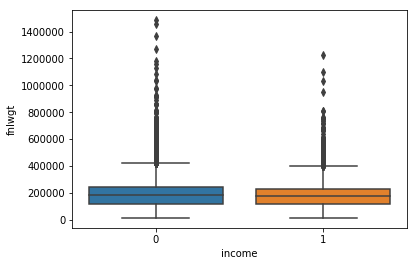

In [39]:
sns.boxplot(x='income', y='fnlwgt', data=data);

In [40]:
unique = data.fnlwgt.unique().shape[0]
total = data.shape[0]
print("{} unique of {}".format(unique, total))
print("{0:.2f}%".format(percentage(unique, total)))

21648 unique of 32561
66.48%


Този feature не разбрах много какво описва. 

Ето го официалното описание:

> The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. 

> These are: 
* A single cell estimate of the population 16+ for each state.
* Controls for Hispanic Origin by age and sex.
* Controls by Race, age and sex.

> We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.



От данните горе виждаме, че няма голяма връзка с дохода. Също така, 2/3 от всички стойности са уникални, което е признак, че няма да е много полезен при предиктването.

За да видим нагледно връзките между непрекъснатите feature-и, ще покажем корелационната им матрица.


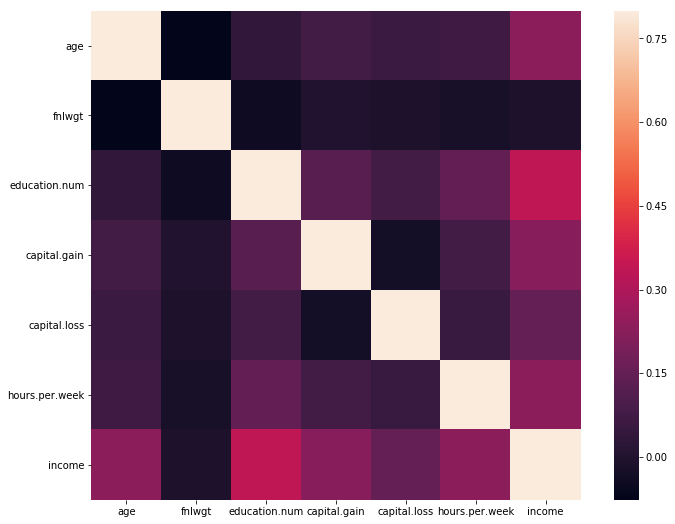

In [41]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

На пръв поглед няма силни връзки между feature-ите, особено между тези, които не включват income.

Може да видим кои feature-и са най-силно корелирани с income.

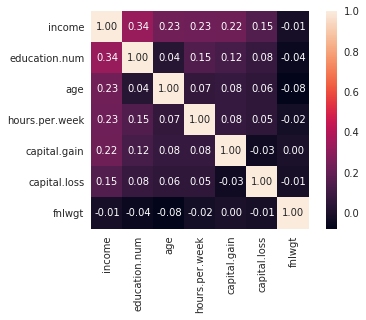

In [42]:
k = 7
cols = corrmat.nlargest(k, 'income')['income'].index
cm = pd.np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.00)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Изглежда най-силна е връзката с education.num, следван от age и hours.per.week. Както очаквахме, fnlwgt, capital.loss и capital.gain са най-слабо корелирани, въпреки че capital.gain е доста повече, отколкото очаквах.

Нека да видим какъв резултат ще имаме за линеен модел, трениран само с най-добрите непрекъснати данни.

In [43]:
X = data[['education.num', 'age', 'hours.per.week']]
y = data['income']

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr_scores = cross_val_score(LogisticRegression(), X, y, cv=10, scoring='accuracy')

print("Scores: {}".format(lr_scores))
print("Mean: {}".format(lr_scores.mean()))

Scores: [ 0.79214001  0.84367322  0.78101966  0.77211302  0.7767199   0.78685504
  0.78409091  0.78132678  0.79115479  0.7791769 ]
Mean: 0.7888270227270842


Да пробваме да ги scale-нем.

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression()),
])

lr_scores = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy')

print("Scores: {}".format(lr_scores))
print("Mean: {}".format(lr_scores.mean()))

Scores: [ 0.79152594  0.84398034  0.78071253  0.77149877  0.77702703  0.78716216
  0.78439803  0.78071253  0.79146192  0.7791769 ]
Mean: 0.7887656165250576


Не помогна. Random Forest?

In [46]:
from sklearn.ensemble import RandomForestClassifier

lr_scores = cross_val_score(RandomForestClassifier(), X, y, cv=10, scoring='accuracy')

print("Scores: {}".format(lr_scores))
print("Mean: {}".format(lr_scores.mean()))

Scores: [ 0.76420018  0.80712531  0.76965602  0.76750614  0.77027027  0.76934889
  0.77610565  0.77242015  0.77948403  0.76996314]
Mean: 0.7746079791098214


Не подобрихме много "тъпия" модел, който винаги предсказваше 0. Само с 1-2%. Това до някъде е нормално, все пак видяхме, че няма feature със силна релация към income-а. Пък и използваме по-малко от половината feature-и в момента.

Нека разгледаме и категорните данни.

In [47]:
categorical_cols

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')

### Workclass

In [48]:
data.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

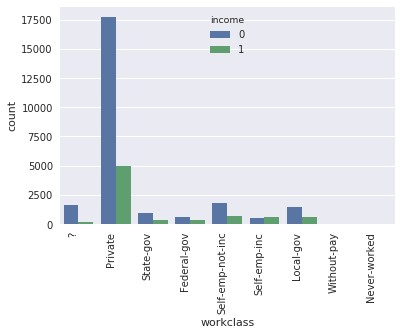

In [49]:
ax = sns.countplot('workclass', hue='income', data=data)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

Най-много хора работят в частния сектор. 
Най-голям процент от хора, правещи над 50к, имаме за тези, които развиват собствен бизнес, следвани от тези, които работят на държавна позиция (Self-emp-inc и Federal-gov).

Притеснително е, че имаме доста записи с неизвестни данни. Единият вариант за попълването им е да ги причислим към Private сектора, тъй като той е най-често срещаният by far. Другият вариант е да се помъчим да ги попълним, като използваме данните от другите feature-и, но това не съм го пробвал. 

### Education

In [50]:
data.education.value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

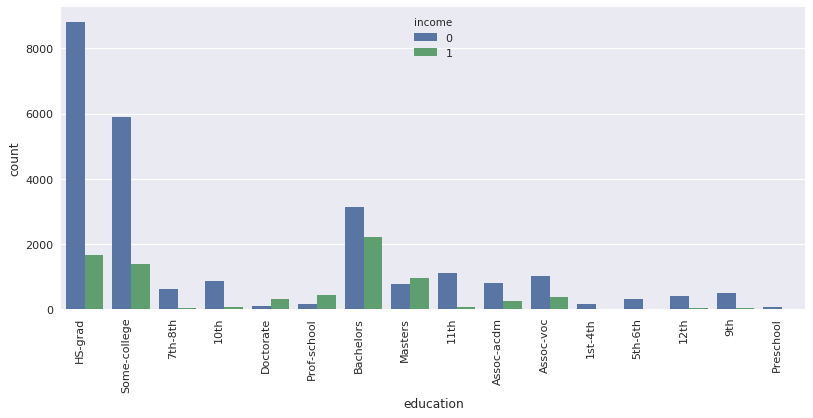

In [51]:
plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot('education', hue='income', data=data)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

Вижда се, че с по-високо образование - по-голям шанс да вземаш повече пари.

Нека обаче ги сортираме по степен на образование, за да се виждат по-хубаво.

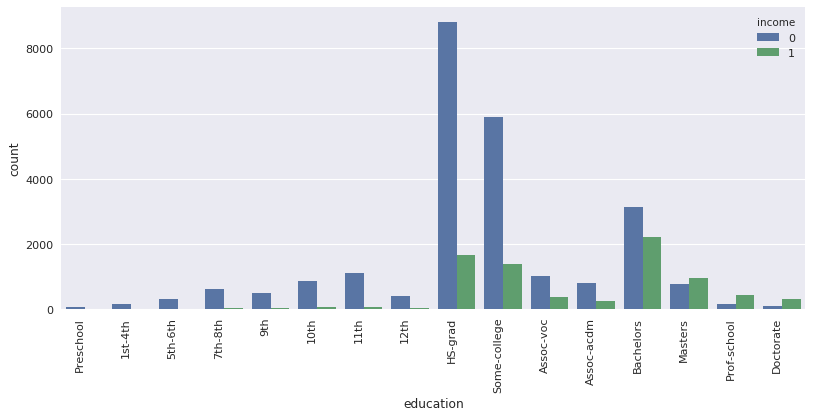

In [52]:
education_ordered = [ 'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 
                     'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 
                     'Prof-school', 'Doctorate']

plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot('education', hue='income', data=data, order=education_ordered)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

По-добре.

А не трябва ли нивото на образованието да корелира с годините учене?

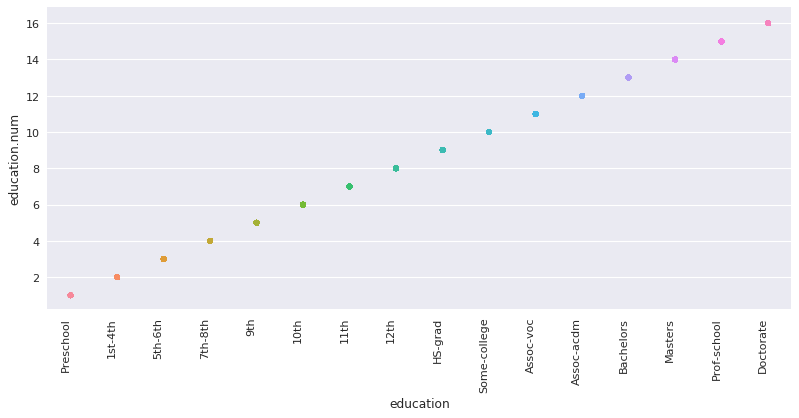

In [53]:
plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.stripplot('education', 'education.num', data=data, order=education_ordered);

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

Очаквано. 

Видяхме, че education и education.num са напълно корелирани и може да изключим едно от двете при тренирането на модела ни.

### Marital status

In [54]:
data['marital.status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

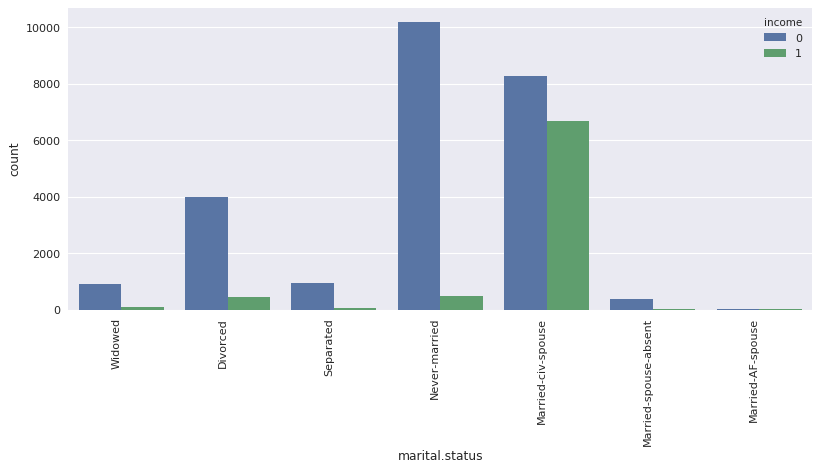

In [55]:
plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot('marital.status', hue='income', data=data)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

In [56]:
married_af = data[data['marital.status'] == 'Married-AF-spouse']

married_af.income.value_counts()

0    13
1    10
Name: income, dtype: int64

Явно income-a доста зависи от това дали си женен. Това е нормално, все пак в общия случай двама човека изкарват повече пари от един.

Тук имаме излишно много възможни стойности за marital.status. Основно данните може да ги разделим на Married и Unmarried.

In [57]:
married_values = ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']
unmarried_values = ['Widowed', 'Divorced', 'Separated', 'Never-married']

marital_status_compressed = data[['marital.status', 'income']].copy()

marital_status_compressed['marital.status'] = marital_status_compressed['marital.status'].replace(
    married_values, 'Married')

marital_status_compressed['marital.status'] = marital_status_compressed['marital.status'].replace(
    unmarried_values, 'Unmarried')


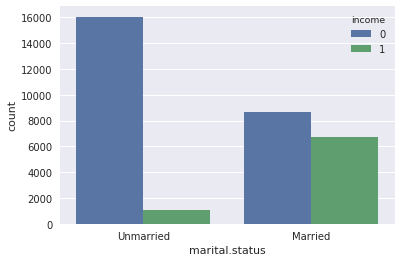

In [58]:
sns.countplot('marital.status', hue='income', data=marital_status_compressed)
plt.show()

Изглежда по-добре

### Occupation

In [59]:
data.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

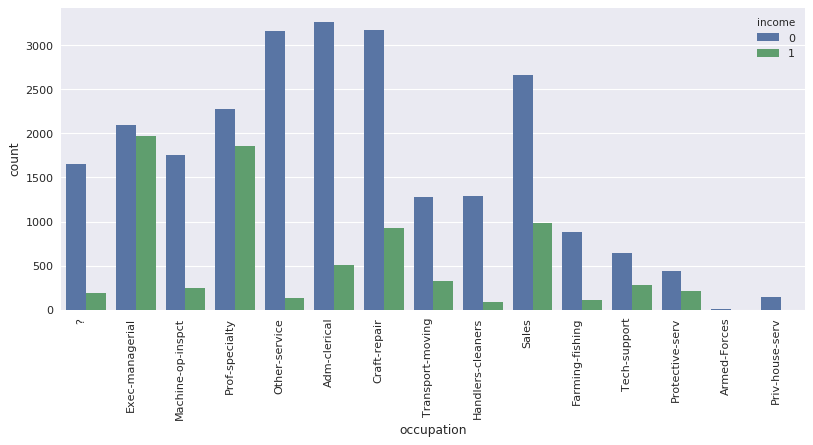

In [60]:
plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot('occupation', hue='income', data=data)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

Виждаме, че има професията има връзка с дохода. Отново обаче имаме доста записи с неизвестни стойности.

### Relationship

In [61]:
data.relationship.value_counts()

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

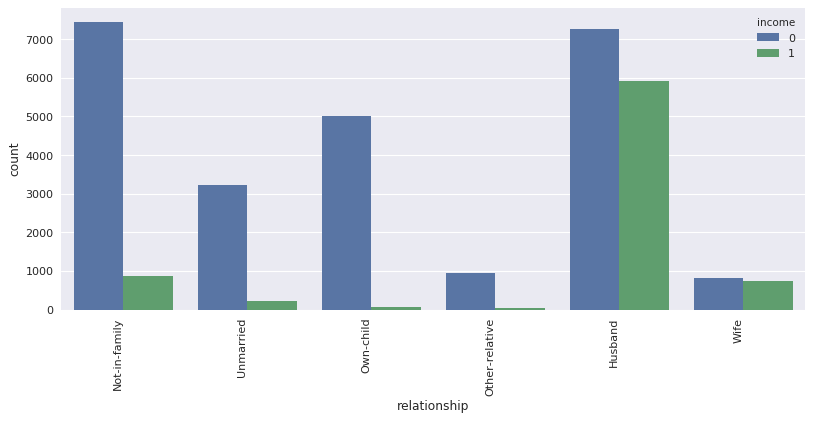

In [62]:
plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot('relationship', hue='income', data=data)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

Тук отново може да обединим два feature-a - Wife и Husband в Married

In [63]:
relationship_compressed = data[['relationship', 'income']].copy()

relationship_compressed['relationship'] = relationship_compressed['relationship'].replace(
    ['Wife', 'Husband'], 'Married')

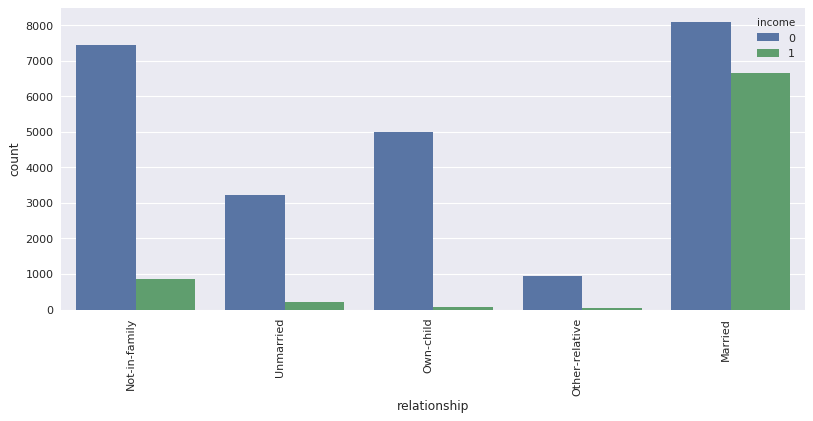

In [64]:
plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot('relationship', hue='income', data=relationship_compressed)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

Вече и в Relationship, и в Marital Status имаме feature Married. Би трябвало да можем да извлечем с доста голяма точност дали човек е женен или не от relationship feature-a.

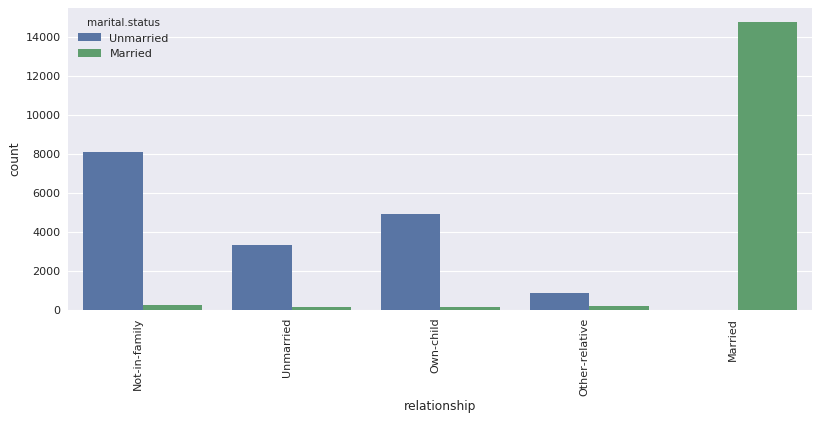

In [65]:
marital_status_compressed['relationship'] = relationship_compressed['relationship']

plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot('relationship', hue='marital.status', data=marital_status_compressed)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

Има голяма корелация между relationship и marital.status. Може да дропнем marital.status.

### Race

In [66]:
data.race.value_counts()

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

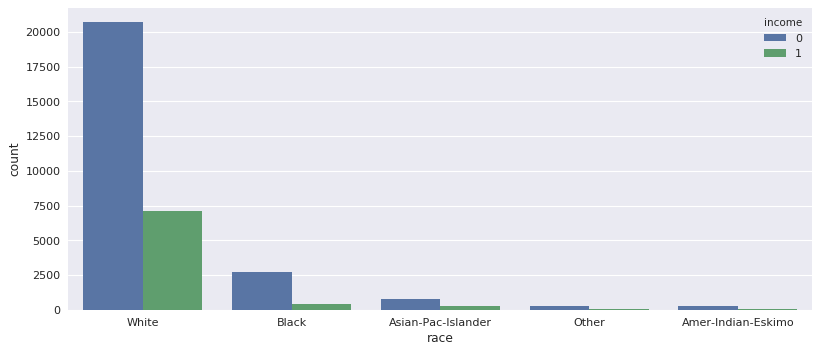

In [67]:
plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.countplot('race', hue='income', data=data);

In [68]:
whites = data[data.race == 'White'].shape[0]
total = data.shape[0]

print("{0:.2f} %".format(percentage(whites, total)))

85.43 %


Данните за расата са доста неравномерно разпределени. Kъм 85% от всички данни са само за White. Затова най-вероятно този фийчър няма да е много съществен при предиктването.

### Gender

In [69]:
data.sex.value_counts()

Male      21790
Female    10771
Name: sex, dtype: int64

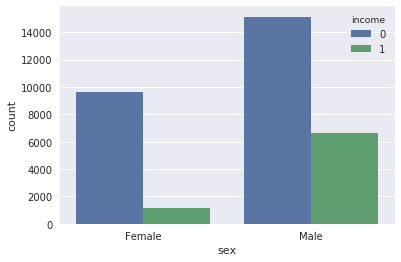

In [70]:
sns.countplot('sex', hue='income', data=data);

Тук отново данните са неравномерно разпределени, защото имаме повече мъже от жени.

### Native country

In [71]:
data['native.country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

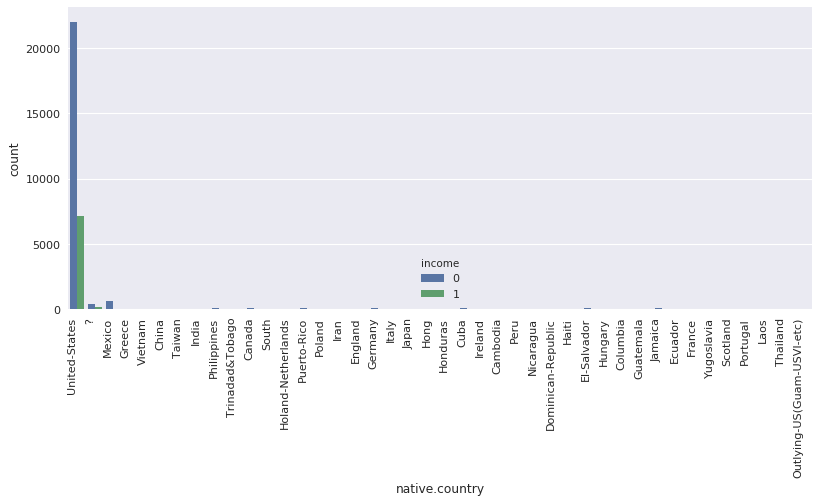

In [72]:
plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.countplot('native.country', hue='income', data=data)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.show()

Почти всички са от US. Ще направим другите Other.

In [73]:
country_compressed = data[['native.country', 'income']].copy()

country_compressed['native.country'] = ['USA' if x == 'United-States' else 'Other' for x in data['native.country']]

In [74]:
country_compressed['native.country'].value_counts()

USA      29170
Other     3391
Name: native.country, dtype: int64

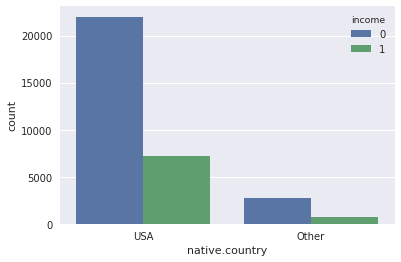

In [75]:
sns.countplot('native.country', hue='income', data=country_compressed);

Разгледахме всички fature-и, които имахме. Видяхме, че от повечето можем да извлечем полезна информация. 
Сега следва малко feature engineering и да си направим данните годни за трениране на модели.

# Да си оправим данните

In [76]:
def dummy_df(df, dummy_list):
    for x in dummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(labels=[x], axis=1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [77]:
data_modified = data.copy()

In [78]:
data_modified.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

Липсващите данни за работната класа ще ги попълним с Private. Тази стойност преобладава много повече от всички останали.

In [79]:
data_modified.workclass = data_modified.workclass.replace('?', 'Private')
data_modified.workclass.value_counts()

Private             24532
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [80]:
data_modified['native.country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

Почти всички записи са от USA, затова всички останали ще ги обединим в една стойност Other.

In [81]:
data_modified['native.country'] = ['USA' if country == 'United-States' or country == '?' else 'Other' 
                                   for country in data_modified['native.country']]
data_modified['native.country'].value_counts()

USA      29753
Other     2808
Name: native.country, dtype: int64

In [82]:
data_modified.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

Горе видяхме, че много голям процент от хората, работещи над 40 часа, изкарват над 50к. 
Следователно ще създадем няколко нови feature-а да отразим това.

In [83]:
data_modified['works_more_than_40'] = (data_modified['hours.per.week'] > 40).astype(float)
data_modified['works_less_than_40'] = (data_modified['hours.per.week'] < 40).astype(float)
data_modified['works_40'] = (data_modified['hours.per.week'] == 40).astype(float)

In [84]:
data_modified['works_more_than_40'].value_counts()

0.0    22980
1.0     9581
Name: works_more_than_40, dtype: int64

In [85]:
data_modified['works_less_than_40'].value_counts()

0.0    24798
1.0     7763
Name: works_less_than_40, dtype: int64

In [86]:
data_modified['works_40'].value_counts()

0.0    17344
1.0    15217
Name: works_40, dtype: int64

Да махнем всички ненужни колони.

In [87]:
X = data_modified.drop(labels=['income', 'fnlwgt', 
                      'education', 'marital.status', 'hours.per.week'], axis=1)
y = data_modified['income']

Ще encode-нем категорийните колони.

In [88]:
X = dummy_df(X, ['workclass', 'occupation',
       'relationship', 'race', 'sex', 'native.country'])

In [89]:
X.shape

(32561, 45)

In [90]:
X.describe()

,age,education.num,capital.gain,capital.loss,works_more_than_40,works_less_than_40,works_40,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native.country_Other,native.country_USA
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,0.294248,0.238414,0.467338,0.029483,0.064279,0.000215,...,0.048156,0.009551,0.031909,0.095943,0.008323,0.854274,0.330795,0.669205,0.086238,0.913762
std,13.640433,2.572720,7385.292085,402.960219,0.455711,0.426120,0.498940,0.169159,0.245254,0.014661,...,0.214099,0.097264,0.175761,0.294518,0.090851,0.352837,0.470506,0.470506,0.280720,0.280720
min,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,37.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,48.000000,12.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,90.000000,16.000000,99999.000000,4356.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
X.head()

,age,education.num,capital.gain,capital.loss,works_more_than_40,works_less_than_40,works_40,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native.country_Other,native.country_USA
0,90,9,0,4356,0.0,0.0,1.0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,82,9,0,4356,0.0,1.0,0.0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
2,66,10,0,4356,0.0,0.0,1.0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
3,54,4,0,3900,0.0,0.0,1.0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
4,41,10,0,3900,0.0,0.0,1.0,0,0,0,...,0,0,0,0,0,1,1,0,0,1


# Да тренираме модели

### Логистична регресия

In [92]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

lr_scores = cross_validate(LogisticRegression(), X, y, cv=strat_k_fold)

scores_df = pd.DataFrame(lr_scores)
scores_df[['test_score', 'train_score']].describe()

,test_score,train_score
count,10.000000,10.000000
mean,0.851110,0.851424
std,0.006223,0.000838
min,0.845209,0.849582
25%,0.846361,0.851057
50%,0.850891,0.851646
75%,0.852460,0.851937
max,0.866093,0.852346


Имаме ~7% увеличение с новите feature-и.

In [93]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, pd.np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = pd.np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [94]:
from sklearn.model_selection import train_test_split

def show_confusion_matrix(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, ['<=50k', '>50k'])

Ще се пробваме да намерим по-добър параметър за логистичната регресия.

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

grid = { 'C': [1, 10, 100, 200, 300, 500, 1000, 5000, 10000] }

search = GridSearchCV(LogisticRegression(), param_grid=grid, cv=strat_k_fold)
search.fit(X, y)

results_df = pd.DataFrame(search.cv_results_)
results_df[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_test_score,params
2,1,0.851294,{'C': 100}
7,2,0.851264,{'C': 5000}
0,3,0.851110,{'C': 1}
3,3,0.851110,{'C': 200}
5,3,0.851110,{'C': 500}


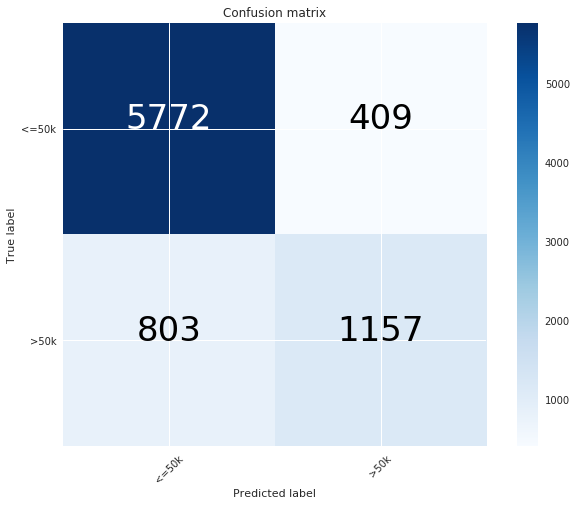

In [96]:
show_confusion_matrix(LogisticRegression(C=100), X, y)

In [97]:
lr_scores = cross_validate(LogisticRegression(C=100), X, y, cv=strat_k_fold)

scores_df = pd.DataFrame(lr_scores)
scores_df[['test_score', 'train_score']].describe()

,test_score,train_score
count,10.000000,10.000000
mean,0.851294,0.851509
std,0.006205,0.000820
min,0.845209,0.849582
25%,0.846514,0.851177
50%,0.850737,0.851746
75%,0.853129,0.852030
max,0.866093,0.852448


85%

Става. Хубаво е, че тrain и test score-а са почти идентични, та поне не овърфитваме.
Лошото е, че моделът много обича да предсказва <=50k, дори когато истинската стойност е >50k

Няма много смисъл, но може да пробваме и с регуларизация.

In [98]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression())])

grid = [
    {
        'classifier': [LogisticRegression()],
        'preprocessing': [None, RobustScaler(), StandardScaler(), MinMaxScaler()],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier': [Ridge(), Lasso()],
        'preprocessing': [None, RobustScaler(), StandardScaler(), MinMaxScaler()],
        'classifier__alpha': [0.001, 0.01, 0.1, 1, 10, 10, 1000, 10000]
    }
]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
search = GridSearchCV(pipe, grid, cv=5)
search.fit(X_train, y_train)

print("Best params:\n{}\n".format(search.best_params_))
print("Best cross-validation score: {:.2f}".format(search.best_score_))

Best params:
{'classifier': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'classifier__C': 100, 'preprocessing': None}

Best cross-validation score: 0.85


Очаквано, не постигнахме по-добри резултати с Ridge и Lasso.

Next, RandomForestClassifier

# Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier

lr_scores = cross_validate(RandomForestClassifier(), X, y, cv=strat_k_fold)

scores_df = pd.DataFrame(lr_scores)
scores_df[['test_score', 'train_score']].describe()

,test_score,train_score
count,10.000000,10.000000
mean,0.840208,0.953721
std,0.007752,0.000551
min,0.830774,0.952670
25%,0.835688,0.953438
50%,0.838630,0.953677
75%,0.842521,0.954078
max,0.857801,0.954581


Тук овърфитваме доста, но може да се пробваме да намерим по-добри параметри.

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('rfc', RandomForestClassifier()),
])

grid = {
    'rfc__n_estimators': [10, 30, 50, 70, 100],
    'rfc__max_depth': [10, 12, 15, 20, 25, 30, 35]
}

search = GridSearchCV(pipeline, cv=strat_k_fold, param_grid=grid)
search.fit(X_train, y_train)

print("Best params:\n{}\n".format(search.best_params_))
print("Best cross-validation score: {:.2f}".format(search.best_score_))

Best params:
{'rfc__max_depth': 12, 'rfc__n_estimators': 70}

Best cross-validation score: 0.86


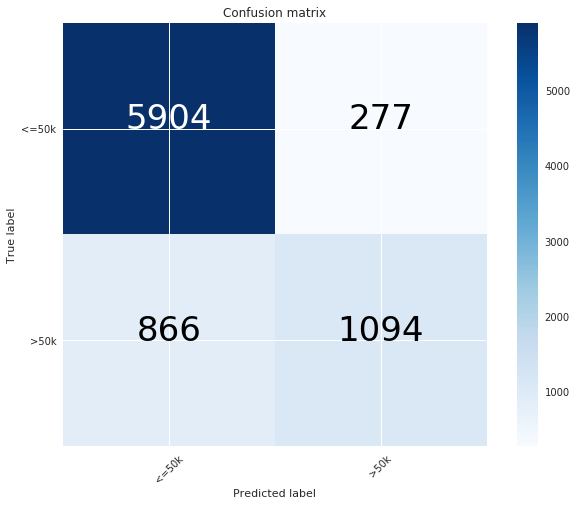

In [101]:
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('rfc', RandomForestClassifier(max_depth=12, n_estimators=70)),
])

show_confusion_matrix(pipeline, X, y)

In [102]:
lr_scores = cross_validate(pipeline, X, y, cv=strat_k_fold)

scores_df = pd.DataFrame(lr_scores)
scores_df[['test_score', 'train_score']].describe()

,test_score,train_score
count,10.000000,10.000000
mean,0.860569,0.874738
std,0.008349,0.000740
min,0.850737,0.872889
25%,0.856726,0.874611
50%,0.857801,0.874834
75%,0.863186,0.875038
max,0.881143,0.875755


86%

Намалихме малко false positives, но нарастнаха false negatives.

Може да пробваме и с SVC

In [103]:
from sklearn.svm import SVC

strat_k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
lr_scores = cross_validate(SVC(), X, y, cv=strat_k_fold)

scores_df = pd.DataFrame(lr_scores)
scores_df[['test_score', 'train_score']].describe()

,test_score,train_score
count,10.000000,10.000000
mean,0.867234,0.872021
std,0.008419,0.000918
min,0.858108,0.870295
25%,0.862408,0.871941
50%,0.864578,0.872291
75%,0.871391,0.872564
max,0.885135,0.873059


# Conclusion


Стигаме консистентно 86-87% точност с почти всички модели, които пробвахме. Изводът е, че има не малка релация в данните, както видяхме при data exploration-а.